In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

time: 129 μs (started: 2025-04-25 06:04:42 +08:00)


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from CuSP import MEForward # import the forward model module

time: 1.44 s (started: 2025-04-25 06:04:45 +08:00)


In [3]:
help(MEForward) # help information of the forward model

Help on class MEForward in module CuSP.me_forward:

class MEForward(builtins.object)
 |  MEForward(wavebands: torch.Tensor, landeG: float = 2.5, lambda0: float = 630.25, wing=None)
 |
 |  Methods defined here:
 |
 |  __call__(self, Dlambda_D: torch.Tensor, v_los: torch.Tensor, eta_0: torch.Tensor, S10: torch.Tensor, a_damp: torch.Tensor, Bmag: torch.Tensor, theta: torch.Tensor, phi: torch.Tensor)
 |      Compute the forward model for the ME spectrum
 |      Input:
 |          Dlambda_D [mA] -> Doppler width include micro turblence and thermal motion
 |          v_los     [m/s] -> velocity of medium
 |          eta_0     []    -> ratio between the selected absorption and continous absorption
 |          S10       []    -> S1/S0, the ME atomosphere source function: S = S0 + S1*tau
 |          a_damping []    -> damping factor for absorption profile
 |          Bmag      [G]   -> photospherical magnetic field magnitude
 |          theta     [deg] -> angle respective to the z direction
 | 

In [ ]:
# generate the `nums` sets of physical parameters for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nums = 100 # number of sets of physical parameters
# parameter range reference: 10.1007/s11207-014-0497-7
v_D_range = [1,500]
v_los_range = [-7e3,7e3]
eta_0_range = [1,1000]
S10_range = [0.1,10]
a_damp_range = [0.4,0.6]
Bmag_range = [5,5000]
theta_range = [0,np.pi]
phi_range = [0,np.pi]

v_D = torch.exp(torch.rand((nums,1),device=device)*(np.log(v_D_range[1])-np.log(v_D_range[0]))+np.log(v_D_range[0])).cuda()/1e4
v_los = torch.clamp(torch.randn((nums,1), device=device) * v_los_range[1] / 3, min=v_los_range[0], max=v_los_range[1]).cuda()
eta_0 = torch.exp(torch.rand((nums,1),device=device)*(np.log(eta_0_range[1])-np.log(eta_0_range[0]))+np.log(eta_0_range[0])).cuda()
S10 = torch.exp(torch.rand((nums,1),device=device)*(np.log(S10_range[1])-np.log(S10_range[0]))+np.log(S10_range[0])).cuda()
a_damp = torch.exp(torch.rand((nums,1),device=device)*(np.log(a_damp_range[1])-np.log(a_damp_range[0]))+np.log(a_damp_range[0])).cuda()
Bmag = (torch.rand((nums,1),device=device)*(Bmag_range[1]-Bmag_range[0])+Bmag_range[0]).cuda()
theta = (torch.rand((nums,1),device=device)*(theta_range[1]-theta_range[0])+theta_range[0]).cuda()
phi = (torch.rand((nums,1),device=device)*(phi_range[1]-phi_range[0])+phi_range[0]).cuda()

time: 2.26 ms (started: 2025-04-25 06:10:56 +08:00)


In [ ]:
"""
Usage of the forward model module:
    a centeral wavelength  `lambda0`, and the wavebands of interest `ll`(`lm`) should be specified.
    `wing` sets up the line's wing to normalize the line profile.
    `landeG` is the Lande factor of the line, default is 2.5.
"""
lambda0 = 630.25 # nm
dlambda = 4e-4   # nm
nlambda = 100    # sample numbers
ll      = lambda0-0.5*dlambda*nlambda+np.arange(nlambda)*dlambda
lm = np.linspace(lambda0-50e-4*0.5*5,lambda0+50e-4*0.5*5,7)
ll_tensor = torch.from_numpy(ll).float().cuda()
lm_tensor = torch.from_numpy(lm).float().cuda()

# define the forward model
forward_cont = MEForward(ll_tensor,lambda0=630.25,landeG=2.5,wing=ll.min()) # continuum
forward_samp = MEForward(lm_tensor,lambda0=630.25,landeG=2.5,wing=ll.min()) # sample points (like the instrument's resolution)

time: 9.38 ms (started: 2025-04-25 06:10:58 +08:00)


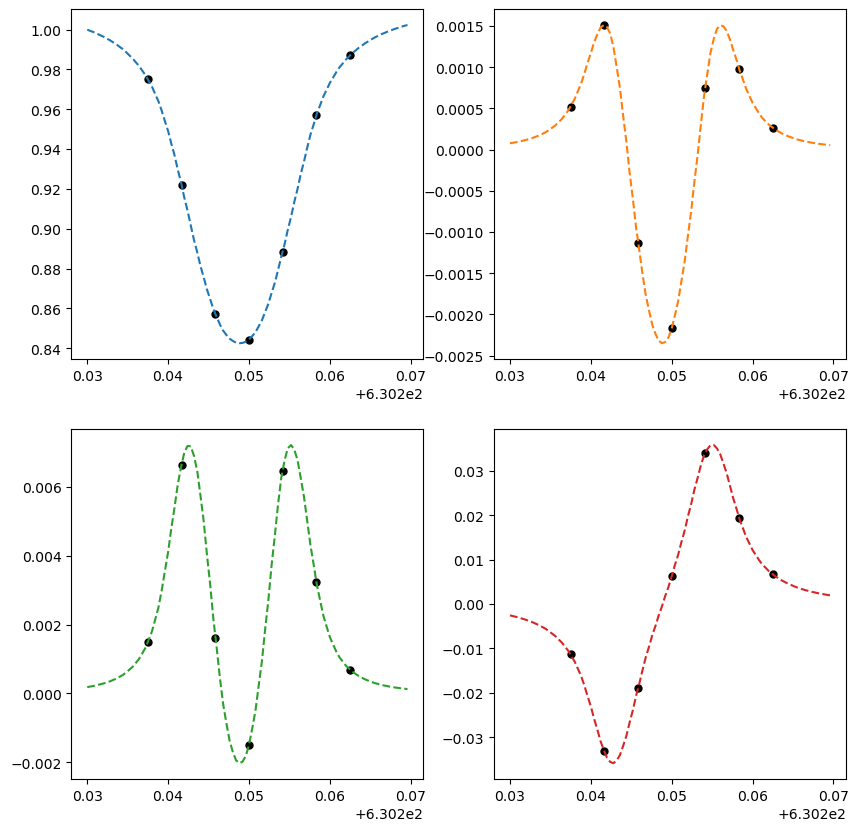

time: 209 ms (started: 2025-04-25 06:10:59 +08:00)


In [ ]:
"""
Computing the IQUV profiles parallelly by Cuda.
It can be very fast to compute several profiles at once.
"""
I_cont,Q_cont,U_cont,V_cont = forward_cont(v_D,v_los,eta_0,S10,a_damp,Bmag,theta,phi)
I_samp,Q_samp,U_samp,V_samp = forward_samp(v_D,v_los,eta_0,S10,a_damp,Bmag,theta,phi)

choice = np.random.randint(0,nums) # random choice of a set of physical parameters
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(lm,I_samp[choice].cpu().numpy().squeeze(),label='I',c='k',ls='',marker='o',ms=5)
plt.plot(ll,I_cont[choice].cpu().numpy().squeeze(),label='I_ctn',c='C0',ls='--')
plt.subplot(2,2,2)
plt.plot(lm,Q_samp[choice].cpu().numpy().squeeze(),label='Q',c='k',ls='',marker='o',ms=5)
plt.plot(ll,Q_cont[choice].cpu().numpy().squeeze(),label='Q_ctn',c='C1',ls='--')
plt.subplot(2,2,3)
plt.plot(lm,U_samp[choice].cpu().numpy().squeeze(),label='U',c='k',ls='',marker='o',ms=5)
plt.plot(ll,U_cont[choice].cpu().numpy().squeeze(),label='U_ctn',c='C2',ls='--')
plt.subplot(2,2,4)
plt.plot(lm,V_samp[choice].cpu().numpy().squeeze(),label='V',c='k',ls='',marker='o',ms=5)
plt.plot(ll,V_cont[choice].cpu().numpy().squeeze(),label='V_ctn',c='C3',ls='--')
plt.show()